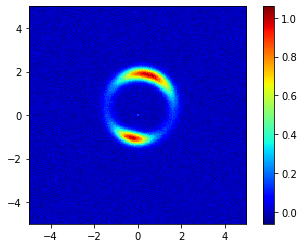

In [5]:
import numpy as np
from matplotlib import pyplot as plt

def gauss_2d(x, y, spar):
    '''
    spar[0]: Normalization [1]:xcenter [2]:ycenter [3]:effective radius 
    '''
    (xnew, ynew)=(x-spar[1],y-spar[2])
    r=np.sqrt(xnew**2.+ynew**2.)
    return spar[0]*np.exp(-0.5*(r/spar[3])**2)

def def_sis(x, y, lpar):
    '''
    Calculating the deflection angle of an SIS mass profile following Kormann 1993
    0:Einstein radius 1:xcenter  2:ycenter  
    '''
    (xnew, ynew)=(x-lpar[1],y-lpar[2])
    r_sie=np.sqrt(x**2.+y**2.)
    alpha_x=xnew/(r_sie+(r_sie==0))
    alpha_y=ynew/(r_sie+(r_sie==0))
    return (lpar[0]*alpha_x, lpar[0]*alpha_y)

def add_noise(image,skylevel,exposure):
    image_= image + skylevel
    counts = image_ * exposure
    counts = np.random.poisson(counts, image_.shape)
    image = counts*1.0/exposure - skylevel
    return image

spar = [1.0, 0.1, 0.4, 0.2]
lpar = [1.5, 0.0, 0.0]
hw = 100
dpix = 0.05
xcoord = np.arange(-hw,hw+1)*dpix
ycoord = np.arange(-hw,hw+1)*dpix
xcoord,ycoord = np.meshgrid(xcoord,ycoord)
deflx,defly = def_sis(xcoord, ycoord, lpar)
lensed_data = gauss_2d(xcoord-deflx,ycoord-defly,spar)
lensed_data = add_noise(lensed_data,0.5,2000)

visual_kwgs = {'origin':'lower','extent':[xcoord.min(),xcoord.max(),ycoord.min(),ycoord.max()],'cmap':'jet'}
plt.imshow(lensed_data,**visual_kwgs)
plt.colorbar()
plt.show()

Mock = np.copy(lensed_data)

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
class generate_lensed_image(nn.Module):
    def __init__(self):
        super().__init__()
        self.lpar = nn.Parameter(torch.tensor([1.6, 0.0, 0.0],requires_grad=True, dtype=torch.float))
        self.spar = nn.Parameter(torch.tensor([1.0, 0.0, 0.0, 0.3],requires_grad=True, dtype=torch.float))
        
    def gauss_2d(self, x, y, spar):
        '''
        spar[0]: Normalization [1]:xcenter [2]:ycenter [3]:effective radius 
        '''
        (xnew, ynew)=(x-spar[1],y-spar[2])
        r=torch.sqrt(xnew**2.+ynew**2.)
        return spar[0]*torch.exp(-0.5*(r/spar[3])**2)
    
    def def_sis(self, x, y, lpar):
        '''
        Calculating the deflection angle of an SIS mass profile following Kormann 1993
        0:Einstein radius 1:xcenter  2:ycenter  
        '''
        (xnew, ynew)=(x-lpar[1],y-lpar[2])
        r_sie=torch.sqrt(x**2.+y**2.)
        alpha_x=xnew/(r_sie+(r_sie==0))
        alpha_y=ynew/(r_sie+(r_sie==0))
        return (lpar[0]*alpha_x, lpar[0]*alpha_y)
    
    def add_noise(self, image, skylevel, exposure):
        image = image.detach().numpy() 
        image_= image + skylevel
        counts = image_ * exposure
        counts = np.random.poisson(counts, image_.shape)*1.0
        counts = torch.from_numpy(counts)
        counts.requires_grad_()
        image = counts*1.0/exposure - skylevel
        return image
       
    def forward(self, x, y, skylevel,exposure):
        # Computes the outputs / predictions
        deflx,defly = self.def_sis(x, y, self.lpar)
        lensed_data = self.gauss_2d(x-deflx,y-defly,self.spar)
        #lensed_data = self.add_noise(lensed_data,skylevel,exposure)
        return lensed_data


In [13]:
x = torch.from_numpy(xcoord)
y = torch.from_numpy(ycoord)
data = torch.from_numpy(Mock)
# Now we can create a model and send it at once to the device
model = generate_lensed_image()
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-5
n_epochs = 100000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x,y,0.5,2000.0)
    
    loss = loss_fn(data, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('lpar', tensor([1.6000, 0.0000, 0.0000])), ('spar', tensor([1.0000, 0.0000, 0.0000, 0.3000]))])
OrderedDict([('lpar', tensor([nan, nan, nan])), ('spar', tensor([nan, nan, nan, nan]))])


#### Todo
Short aim(nextweek)
- PSF convolution
- elliptical lens/source
- add poisson and gaussian noise?
- code refactor

Middle aim(this month)
- irregular source light model
- baeysian sampling(Pyro,Polynest?)